In [11]:
import sys, logging, datetime, warnings

warnings.filterwarnings("ignore", message="numpy.dtype size changed")

sys.stdout = open("/home/ailabguest/alessandrodileone/Community-Detection-and-Recommender-Systems/LDA_log/ShowTopics_LDA_Multicore", "w")

logging.basicConfig(filename='/home/ailabguest/alessandrodileone/Community-Detection-and-Recommender-Systems/LDA_log/lda_model.log', format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
from pymongo import MongoClient
import pandas as pd  
import numpy as np
from utils import tokenize_and_stem
from nltk.corpus import stopwords

client = MongoClient('localhost', 27017)
db = client['twitter']

pipeline=[{ "$project": {  "id_user" : 1, "originalTweet" : 1, "hashtag" : 1, "mention" : 1} }]

cursor_list = list(db['tweets'].aggregate(pipeline))

tweets = pd.DataFrame(cursor_list)
data = pd.DataFrame(columns=['Tweets'])
data['Tweets'] = tweets['originalTweet']

myStopWords=set(stopwords.words('english')+list(['http','https']))

docs = data['Tweets']

documents = [tokenize_and_stem(s, stopwords=myStopWords) for s in docs]

print( datetime.datetime.now(), ' : data processing ended')

In [ ]:
from gensim import corpora, models, similarities

dictionary = corpora.Dictionary(documents)
print()
print(datetime.datetime.now(), ' : dictionary created')

In [ ]:
corpus = [dictionary.doc2bow(text) for text in documents]
print()
print(datetime.datetime.now(), ' : vectorization completed')

Topic Coherence is a measure used to evaluate topic models: methods that automatically generate topics from a collection of documents, using latent variable models.

Each such generated topic consists of words, and the topic coherence is applied to the top N words from the topic. It is defined as the average / median of the pairwise word-similarity scores of the words in the topic (e.g. PMI).

A good model will generate coherent topics, i.e., topics with high topic coherence scores. Good topics are topics that can be described by a short label, therefore this is what the topic coherence measure should capture.

How to find the optimal number of topics for LDA?

My approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.

Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics.

If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

The compute_coherence_values() trains multiple LDA models and provides the models and their corresponding coherence scores.

The last step is to find the optimal number of topics.We need to build many LDA models with different values of the number of topics (k) and pick the one that gives the highest coherence value. Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics. If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

In [ ]:
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model =models.LdaMulticore(corpus, id2word=dictionary, num_topics=num_topics, passes=5, workers=9)
        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
print()
print( datetime.datetime.now(), ' : coherence eval _ start' )

limit=15; 
start=5; 
step=2;

model_list, coherence_values = compute_coherence_values(dictionary=dictionary, 
                                                        corpus=corpus, 
                                                        texts=documents, 
                                                        start=start, limit=limit, step=step)

print()
print(datetime.datetime.now(), ' : coherence eval _ end' )

In [12]:
print()
print('Coherence values:\n' )

# Print the coherence scores

x = range(start, limit, step)

for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Coherence values:

Num Topics = 5  has Coherence Value of 0.266 <br>
Num Topics = 7  has Coherence Value of 0.2682<br>
Num Topics = 9  has Coherence Value of 0.2706<br>
Num Topics = 11  has Coherence Value of 0.3071<br>
Num Topics = 13  has Coherence Value of 0.2653<br>

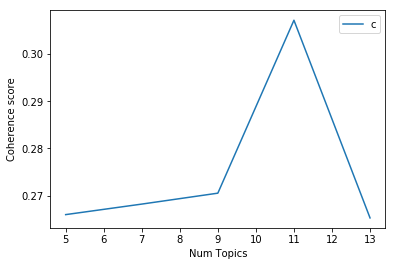

In [10]:
import matplotlib.pyplot as plt

# Show graph

plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
print()
print( datetime.datetime.now(), ' : model training _ start' )

lda = models.LdaMulticore(corpus, id2word=dictionary, num_topics=9, passes=100, workers=9)
print()
print( datetime.datetime.now(), ' : model training _ end' )

In [ ]:
print()
print('----------------------------------------------------------------------------------------------------------------------')
print()

#Show first n important word in the topics:
lda.show_topics(7,5)